In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [2]:
print("Projeto OdontoPrev - Detecção de Padrões Comportamentais\n")

Projeto OdontoPrev - Detecção de Padrões Comportamentais



In [3]:
n = 500

data = {
    'Paciente_ID': range(1, n+1),
    'Idade': np.random.randint(18, 75, n),
    'Sexo': np.random.choice(['M', 'F'], n),
    'Historico_Tratamento': np.random.choice(['Tratamento_A', 'Tratamento_B', 'Tratamento_C'], n),
    'Faltas': np.random.poisson(1, n),  # média ~1 falta
    'Frequencia_Consultas': np.random.randint(1, 6, n),
    'Tipo_Plano': np.random.choice(['Básico', 'Intermediário', 'Premium'], n)
}

In [4]:
df = pd.DataFrame(data)
print(df.head())

   Paciente_ID  Idade Sexo Historico_Tratamento  Faltas  Frequencia_Consultas  \
0            1     19    M         Tratamento_C       2                     5   
1            2     27    M         Tratamento_B       0                     5   
2            3     74    F         Tratamento_A       0                     2   
3            4     61    F         Tratamento_B       2                     4   
4            5     52    F         Tratamento_B       0                     1   

      Tipo_Plano  
0  Intermediário  
1  Intermediário  
2        Premium  
3        Premium  
4         Básico  


In [5]:
df['Sinistro'] = (
    (df['Faltas'] > 2).astype(int) +
    (df['Idade'] > 60).astype(int) +
    (df['Tipo_Plano'] == 'Básico').astype(int) +
    np.random.binomial(1, 0.1, n)  # ruído
)
df['Sinistro'] = (df['Sinistro'] >= 2).astype(int)

print("Exemplo dos dados simulados:")
print(df.head())

Exemplo dos dados simulados:
   Paciente_ID  Idade Sexo Historico_Tratamento  Faltas  Frequencia_Consultas  \
0            1     19    M         Tratamento_C       2                     5   
1            2     27    M         Tratamento_B       0                     5   
2            3     74    F         Tratamento_A       0                     2   
3            4     61    F         Tratamento_B       2                     4   
4            5     52    F         Tratamento_B       0                     1   

      Tipo_Plano  Sinistro  
0  Intermediário         0  
1  Intermediário         0  
2        Premium         0  
3        Premium         0  
4         Básico         0  


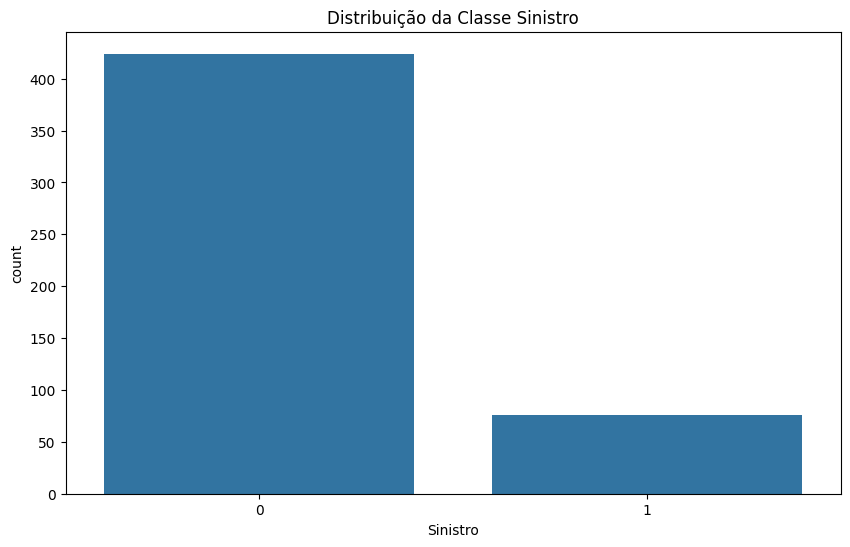

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Sinistro', data=df)
plt.title('Distribuição da Classe Sinistro')
plt.show()

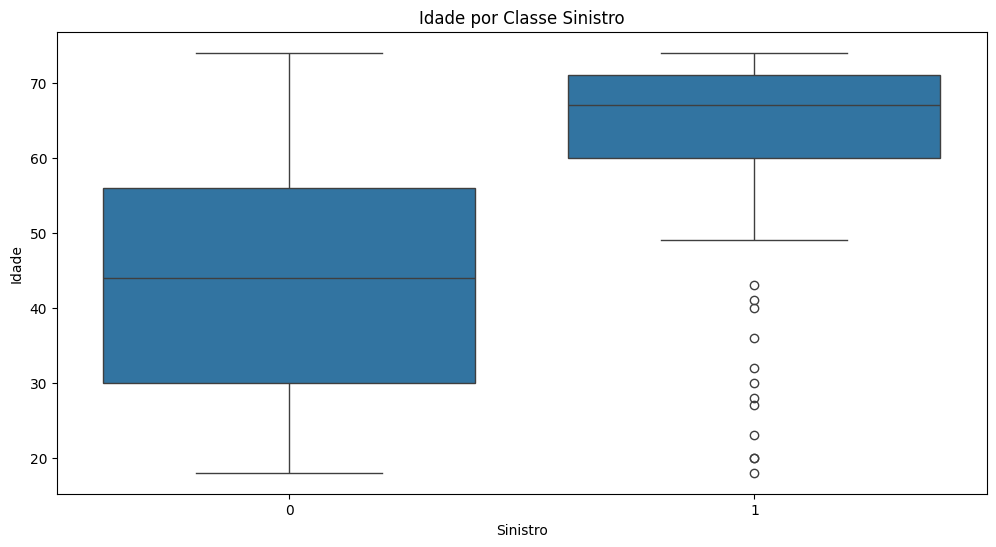

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sinistro', y='Idade', data=df)
plt.title('Idade por Classe Sinistro')
plt.show()

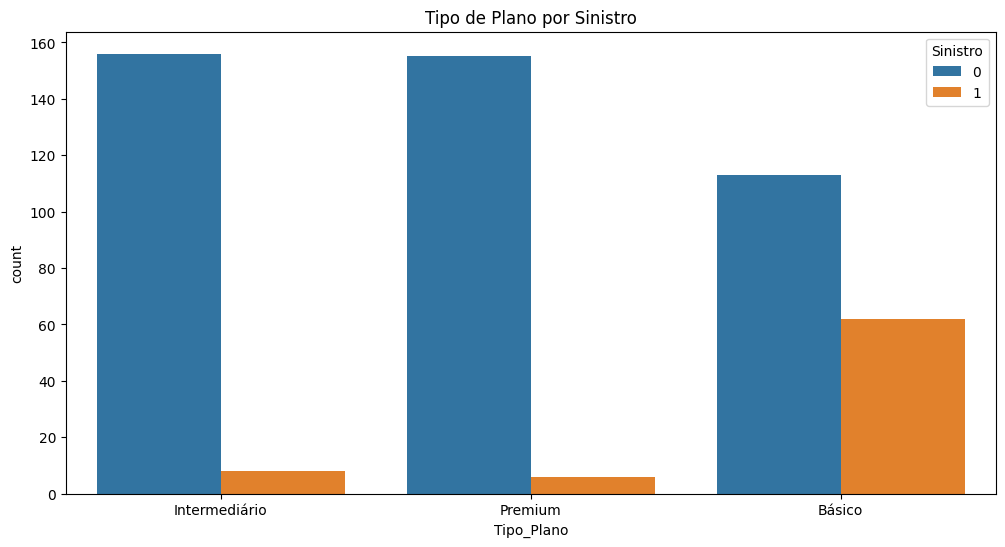

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Tipo_Plano', hue='Sinistro', data=df)
plt.title('Tipo de Plano por Sinistro')
plt.show()

In [9]:
X = df.drop(columns=['Paciente_ID', 'Sinistro'])
y = df['Sinistro']

In [10]:
X = df.drop(columns=['Paciente_ID', 'Sinistro'])
y = df['Sinistro']

In [12]:
cat_features = ['Sexo', 'Historico_Tratamento', 'Tipo_Plano']
num_features = ['Idade', 'Faltas', 'Frequencia_Consultas']

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), cat_features),
    ('scaler', StandardScaler(), num_features)
])

In [13]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [15]:
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)


In [16]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_pre, y_train)

In [17]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [18]:
y_pred = clf.predict(X_test_pre)
y_prob = clf.predict_proba(X_test_pre)[:,1]

In [19]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       127
           1       0.72      0.57      0.63        23

    accuracy                           0.90       150
   macro avg       0.82      0.76      0.79       150
weighted avg       0.89      0.90      0.89       150



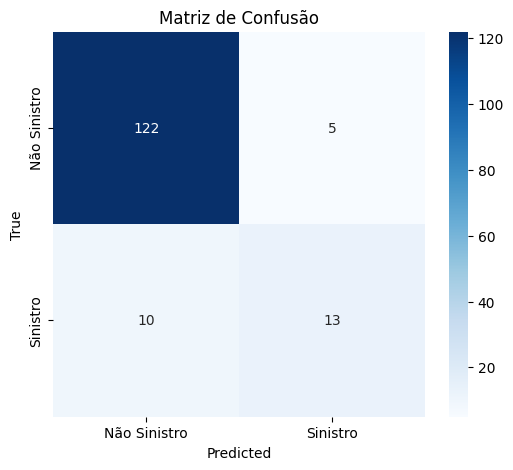

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sinistro', 'Sinistro'], yticklabels=['Não Sinistro', 'Sinistro'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Matriz de Confusão')
plt.show()

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

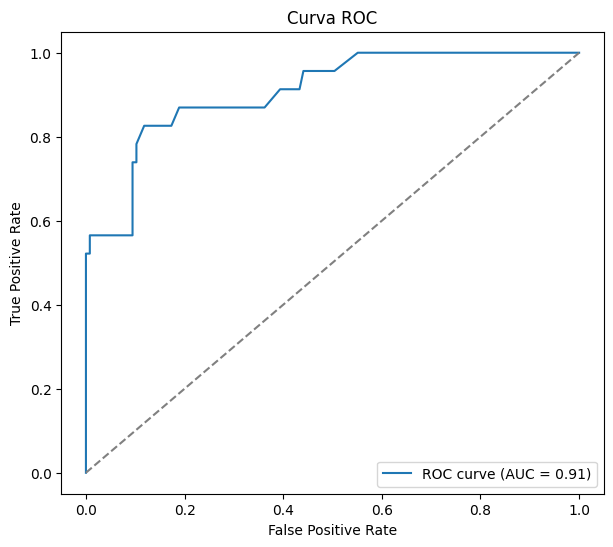

In [22]:
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [23]:
features_num = num_features
features_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_features)
features = np.concatenate([features_cat, features_num])

In [24]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

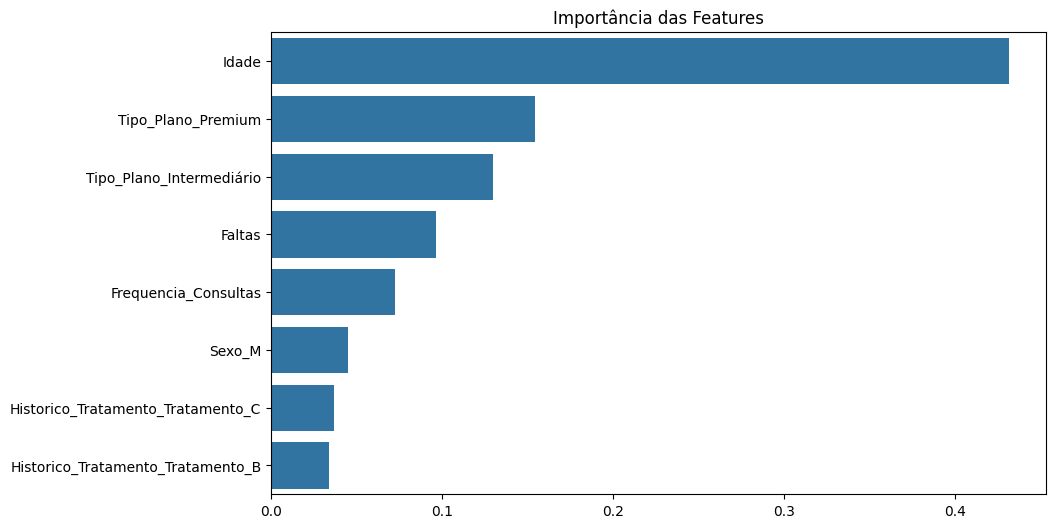

In [25]:
plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title('Importância das Features')
plt.show()

In [26]:
X_full_pre = preprocessor.transform(X)

In [27]:
df['Probabilidade_Sinistro'] = clf.predict_proba(X_full_pre)[:, 1]

In [28]:
def classificar_risco(prob):
    if prob < 0.3:
        return 'Baixo Risco'
    elif prob < 0.7:
        return 'Risco Moderado'
    else:
        return 'Alto Risco'

df['Risco'] = df['Probabilidade_Sinistro'].apply(classificar_risco)

In [29]:
print("\nAnálise detalhada dos pacientes (amostra):")
print(df[['Paciente_ID', 'Idade', 'Sexo', 'Historico_Tratamento', 'Faltas', 'Tipo_Plano', 'Sinistro', 'Probabilidade_Sinistro', 'Risco']].head(10))

print("\nResumo por categoria de risco:")
print(df['Risco'].value_counts())


Análise detalhada dos pacientes (amostra):
   Paciente_ID  Idade Sexo Historico_Tratamento  Faltas     Tipo_Plano  \
0            1     19    M         Tratamento_C       2  Intermediário   
1            2     27    M         Tratamento_B       0  Intermediário   
2            3     74    F         Tratamento_A       0        Premium   
3            4     61    F         Tratamento_B       2        Premium   
4            5     52    F         Tratamento_B       0         Básico   
5            6     69    F         Tratamento_C       1         Básico   
6            7     36    M         Tratamento_C       2  Intermediário   
7            8     44    M         Tratamento_A       2         Básico   
8            9     34    F         Tratamento_A       0         Básico   
9           10     28    M         Tratamento_B       0        Premium   

   Sinistro  Probabilidade_Sinistro        Risco  
0         0                    0.01  Baixo Risco  
1         0                    0.00  Ba

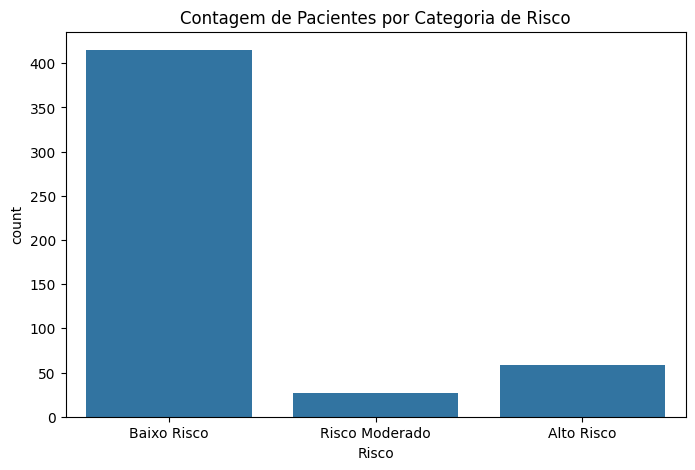

In [30]:
plt.figure(figsize=(8,5))
sns.countplot(x='Risco', data=df, order=['Baixo Risco','Risco Moderado','Alto Risco'])
plt.title('Contagem de Pacientes por Categoria de Risco')
plt.show()